# <center> Accelerating approximate quantum compiling</center>

<center>IBM Research Ireland, 2021-2022</center>

## Introduction

### Problem Statement

1. Our approach is about a system and method to find the best approximate compilation, which represents a given circuit by the universal gates: $\texttt{CNOT}$ and 1-qubit rotations.
2. To achieve zero compilation  error, we need at least $O(4^n)$ $\texttt{CNOTs}$, which is not desirable given the limited depth constraint, if it is feasible at all.
3. Instead, we adopt the approximate quantum compiling formulation in the following form:

$\hspace{5em} \Theta^* = \arg \min_{\Theta \in R^p} \|V(\Theta) - U\|^2_F, \quad V, U \in \texttt{SU}(2^n),$

where:

   - $U$ is a *target* (special) unitary matrix we want to represent as a quantum circuit with a reasonable accuracy.
   - $V(\Theta)$ is an *approximating* quantum circuit parametrized by angles $\Theta \in R^p$.
   - the number of angle variables $|\Theta| = p$ is much less than the number of qubits $n$, $p \ll n$.

4. It can be tackled as a two-stage task: a) finding  the structure of the circuit consisted of $\texttt{CNOTs}$ and rotation gates, b) finding the best rotation angles $\Theta$. The former problem is very difficult, the latter is more tractable given a *fixed* structure of approximating circuit. 
5. We focus here on the second task where the best approximation can be in principle found by optimization over the circuit parameters $\Theta$. The quasi-Newton $\texttt{L-BFGS}$ optimizer is possibly the best method for this kind of problems.
6. The work presented here is based on research ideas described in the paper [1].

### Approximating Circuit

1. **Compilation** is the mapping of a given  circuit (or unitary matrix $U$) to a circuit that can be implemented in hardware.
2. Define a $\texttt{CNOT}$ <i>unit block</i> $C_{jk}(\Theta_1,\Theta_2,\Theta_3,\Theta_4)$ acting on qubit $j$ (control) and qubit $k$ (target) as:

<!-- <center><img src="mydocs/unit_block.png" width="200"/></center> -->
<!-- 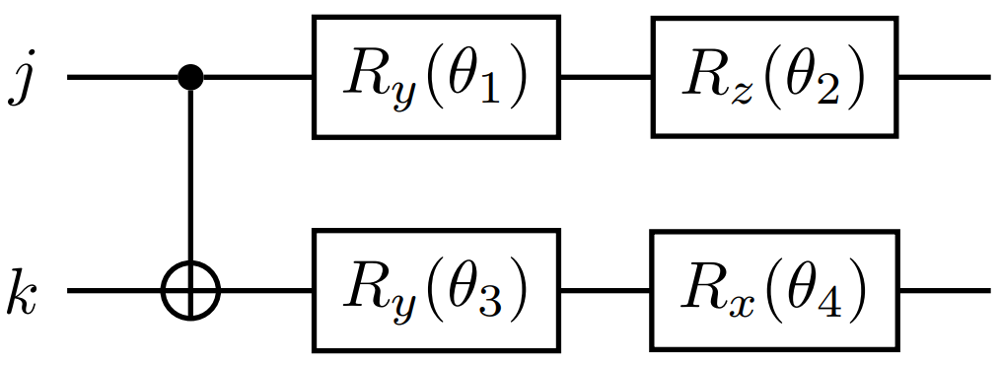 -->
<!-- (1) Jupyter allows one (!) image per cell; (2) <div></div> must present. -->
<div>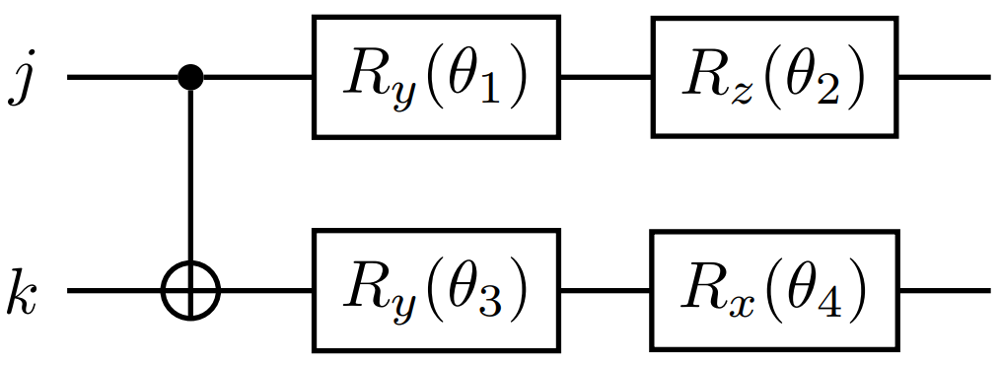</div>

3. An $\texttt{CNOT}$ unit block can be seen as a $4 \times 4$ unitary matrix applied to $j$ and $k$ qubits and parametrized by 4 parameters. 
4. Approximating quantum  circuit (**ansatz**),  parametrized by the angles $\Theta=(\Theta_1, \Theta_2, \ldots)$, can be decomposed into a network of 2-qubit $\texttt{CNOT}$ unit blocks preceded by the *front layer* of universal 1-qubit gates, represented by rotation gates $R_y$, $R_z$. For example, for 5 qubits and $L=5$ unit blocks: 

<!-- <center><img src="mydocs/circuit.png", width="500"/></center> -->
<!-- 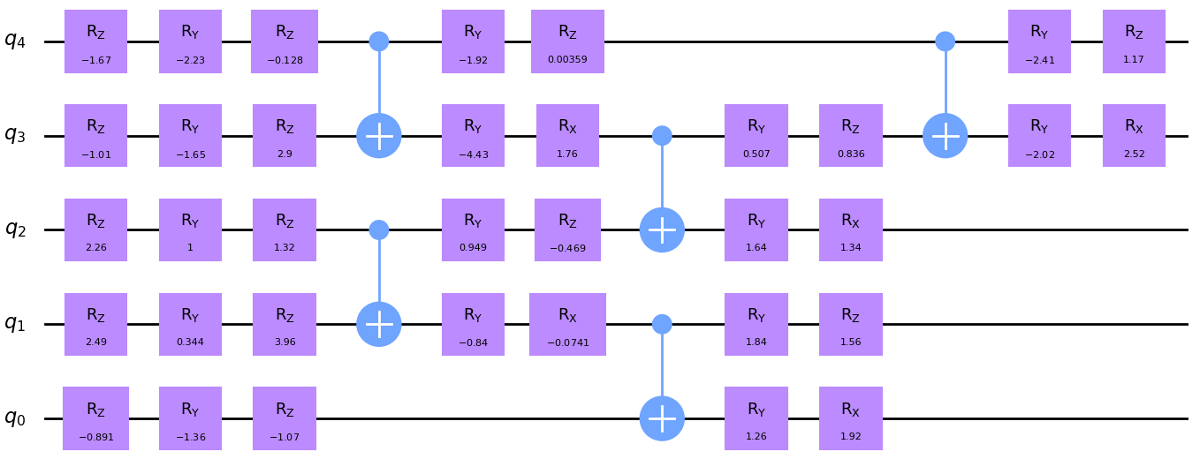 -->
<!-- (1) Jupyter allows one (!) image per cell; (2) <div></div> must present. -->
<div>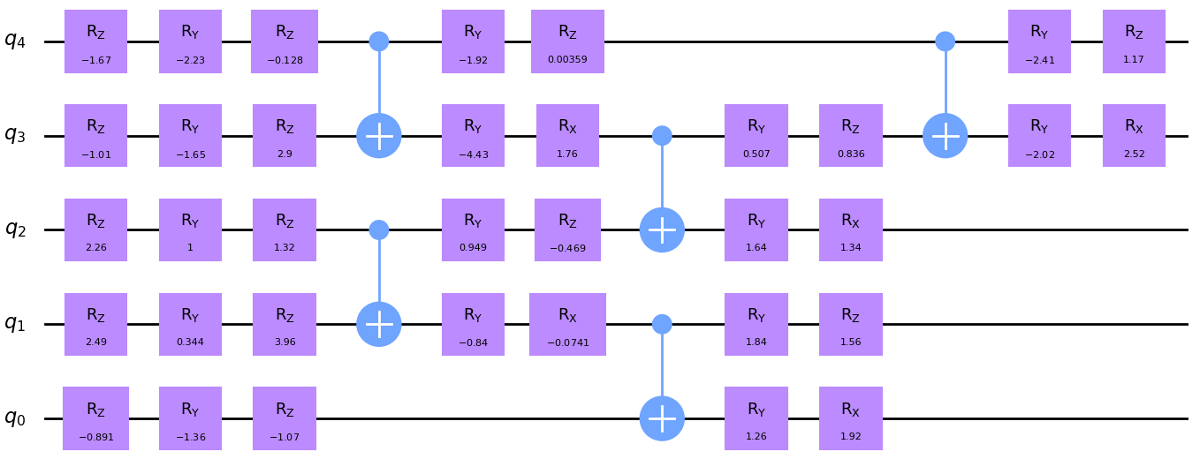</div>

5. Ansatz can be seen as a collection of a front layer ($F$) and several $\texttt{CNOT}$ layers $(C_0, C_1, \ldots , C_{L-1})$, i.e., every unit block $C_i$ represents a single layer.
6. Ansatz matrix is a product: $V(\Theta) = C_{L-1} \, \cdots \, C_1 \, C_0 \, F$, where $L$ is the *circuit depth* and each layer is associated with corresponding matrices $F$ and $C_i$, $i = 1 \ldots L$. In implementation it is convenient to decompose the matrix $F$ into the sub-layers of 1-qubit operations.
7. All the layer matrices have size $2^n \times 2^n$, where $n$ is the number of qubits, and matrices are expanded to the full size ($2^n \times 2^n$) by interleaving  with identity matrices of suitable sizes via Kronecker product. 
8. Fast implementation does **not** construct the matrices $F$ and $C_i$ explicitly.
9. Important characteristics of the ansatz are *layout* and *connectivity*. We usually use "spin" layout and full connectivity, although other options are also possible. The example of "spin" layout for 3 qubits:

<!-- <center><img src="mydocs/spin.png", width="500"/></center> -->
<!-- 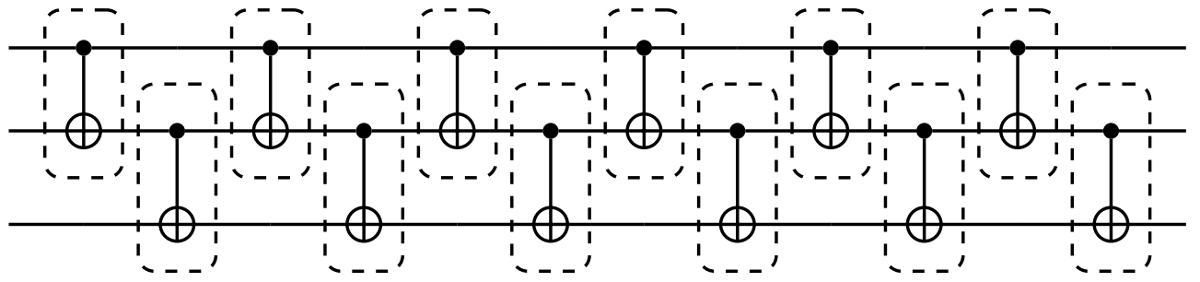 -->
<!-- (1) Jupyter allows one (!) image per cell; (2) <div></div> must present. -->
<div>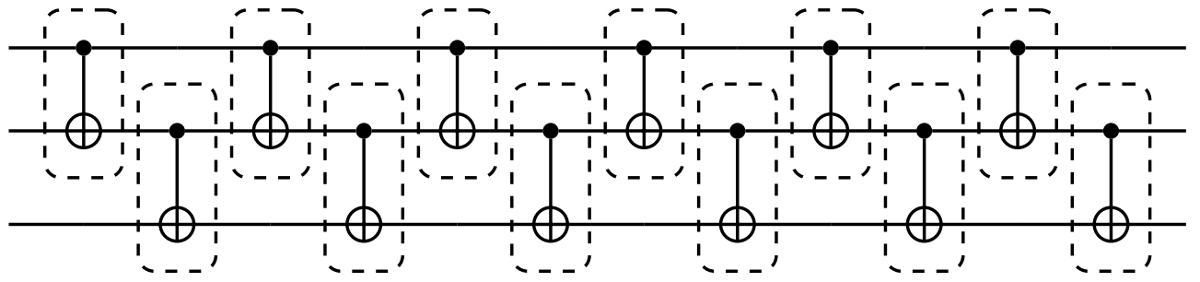

### Accelerated Implementation

Pull request for the accelerated version is currently awaiting on Github:<br>
https://github.com/Qiskit/qiskit-terra/pull/7697

<font color="rgb(128, 128, 0)">*Note: The accelerated implementation is not yet included in the official Qiskit repository (as of May 26, 2022). Instead, one can install Qiskit development environment and use the code available in the pull request. It is assumed that this notebook is placed in (and run from) the root directory of the Qiskit project.*</font>

#### Backtracking

The idea behind backtracking algorithm became popular in machine learning years ago and gains attention in the context of quantum computation. In our default implementation all (full-size) matrices of individual gates and unit blocks have been memorized on forward pass and reused during the backward one. This makes a problem by allocating a lot on memory and is not the most efficient strategy. Few key points about accelerated backtracking are listed below, where we *ignore the front layer* $F$ for simplicity of presentation:
1. Minimization of $\|V - U\|^2_F$ is equivalent to maximization of $\texttt{Re}(\texttt{Tr}(U^{\dagger} V))$. Trace operation admits cyclic permutation of matrix sequences, therefore, we can avoid memorization of intermediate partial products of gate matrices $C_i$.
2. Forward pass: compute $V(\Theta) = C_{L-1} \, \cdots \, C_1 \, C_0$ given the current parameters $\Theta$.
3. Backward pass (gradient computation):

$\qquad\qquad \texttt{Tr}(U^{\dagger} 
\frac{\partial V}{\partial \Theta_{l,k}}) =
\left\langle 
vec(A_l^T), vec\left(\frac{\partial C_l}{\partial \Theta_{l,k}}\right) 
\right\rangle,$

where $\quad A_l = C_{l-1}\,(C_{l-2}\,(\cdots\,(C_0\,
(U^{\dagger}\,V\,C_0^{\dagger}\,)\,C_1^{\dagger}\,)
\,\cdots\,)\,C_{l-1}^{\dagger}\,)\,C_l^{\dagger}.$

4. For every $l$-th gradient component, we compute the trace given matrix $A_l$, then this matrix is updated by multiplication on both sides by corresponding gate matrices $C_l$ and $C_{l+1}$ respectively and proceed to the next gradient component.

#### Standardization 

The matrices $C_i$ are sparse. However, utilization of sparsity is not easy. Here, we transform matrix in the "standard", block-diagonal form that allows to save computations.
1. Any gate matrix $C_i$ can be decomposed into the following product:

$\qquad\qquad C_i = P^T \widetilde{C}_i P,$ 

where $P$ is an easily computable *qubit* permutation matrix (in fact, $1D$ index array!) and $\widetilde{C}_i$ has a *block-diagonal* layout, for example, for 2-qubit gate matrix $G_{4 \times 4}$ expanded to the full size $2^n \times 2^n$:

$\qquad\qquad
\widetilde{C}_i = \begin{pmatrix}
G_{4 \times 4} & \ddots & 0 \\
\ddots & \ddots & \ddots \\
0 & \ddots & G_{4 \times 4}
\end{pmatrix}.$

2. We do **not** actually create neither matrix $C_i$ nor $P$ but only $G_{4 \times 4}$ and a couple of *precomputed* permutation arrays (of size $2^n$) are kept in memory.
3. Consider left-hand side multiplication of some dense, $2^n \times 2^n$ matrix $M$:

$\qquad\qquad C_i M = P^T \widetilde{C}_i P M = P^T (\widetilde{C}_i (P M)).$

3. Multiplication: permute rows of $M$ (same as $P M$ but without actual multiplication); then multiply every block-diagonal sub-matrix $G_{4 \times 4}$ by the corresponding rows of $P M$; finally, apply inverse permutation to the rows of $\widetilde{C}_i P M$.
4. The total number of operations is $O((2^n)^{\bf 2})$ vs $O((2^n)^{\bf 3})$ as for general multiplication of $2^n \times 2^n$ dense matrices.

#### Speedup

The benchmarking result for accelerated implementation vs the default, straightforward one, which expands every gate matrix to its full size using Kronecker product, is shown below. The actual speedup may depend on Numpy version, number of CPU cores and hardware generation, whether the code is executed with multi-threading enabled or not, and so on. However, the performance of accelerated version is always consistently higher.

|<div>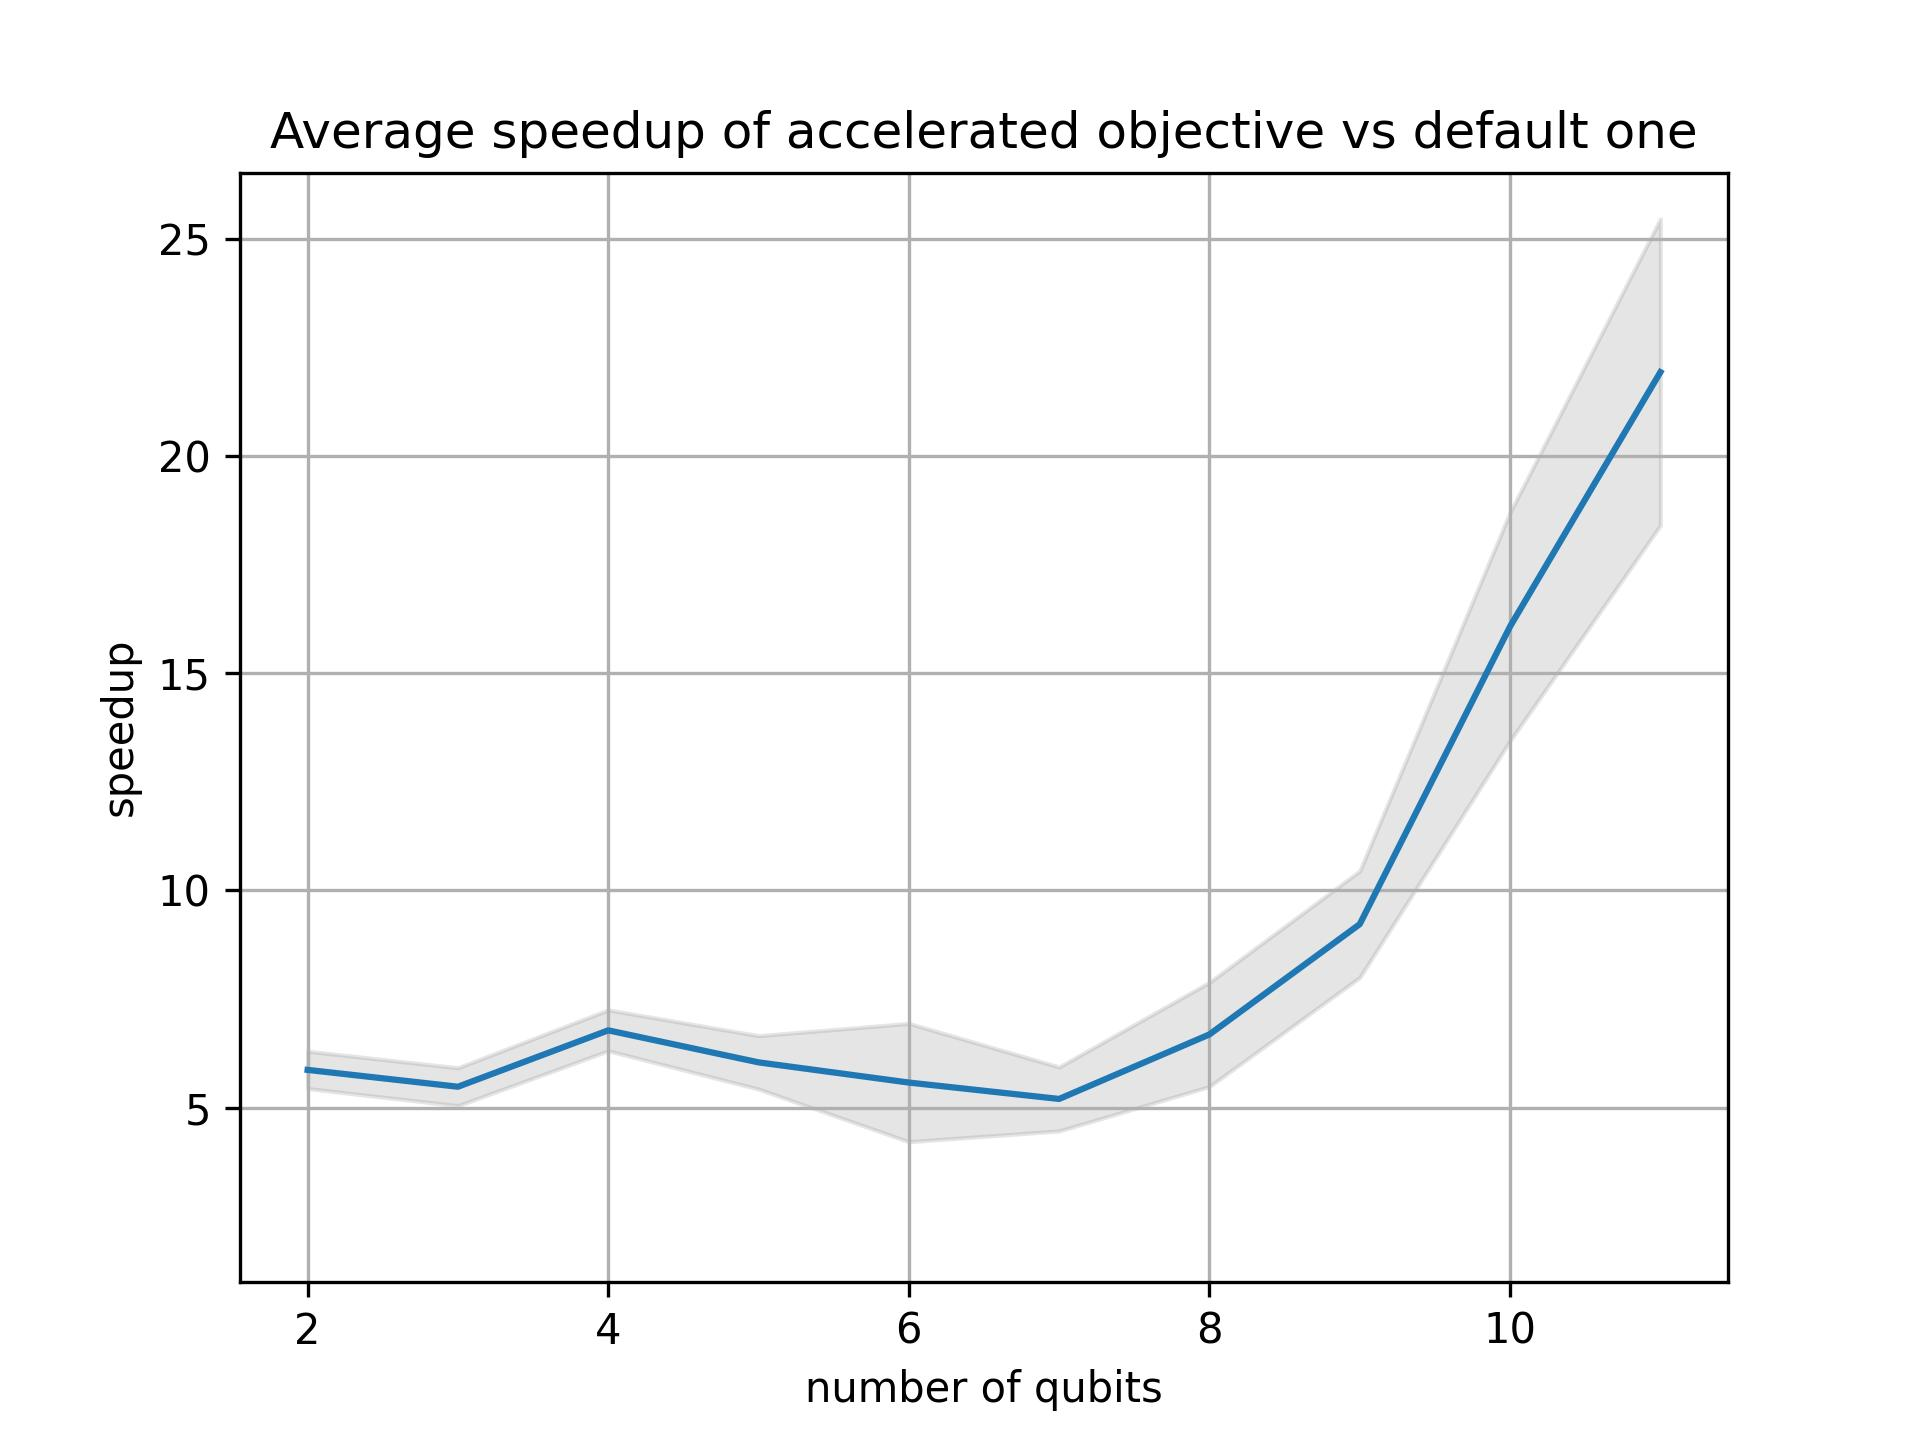|
|---|
|<center>Speedup averaged over various circuit depths as a function of the number of qubits. The dispersion of speedup measurements is also depicted as gray area around the curve (plus/minus standard deviation). In order to produce this chart, we run many simulations with different qubit numbers and circuit depths between 7 and 100. The running times have been aggregated and averaged per qubit number. Every simulation was run in a separate process with a single thread. </center>|

## Algorithm Implementation and Examples

In [1]:
import os
print(f"Working directory: '{os.getcwd()}'")

from test.python.transpiler.aqc.sample_data import ORIGINAL_CIRCUIT, INITIAL_THETAS
import numpy as np
from scipy.stats import unitary_group
from time import perf_counter
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit.quantum_info import Operator
from qiskit.transpiler.synthesis.aqc.aqc import AQC
from qiskit.transpiler.synthesis.aqc.cnot_structures import make_cnot_network
from qiskit.transpiler.synthesis.aqc.cnot_unit_circuit import CNOTUnitCircuit
from qiskit.transpiler.synthesis.aqc.cnot_unit_objective import DefaultCNOTUnitObjective
from qiskit.transpiler.synthesis.aqc.fast_gradient.fast_gradient import FastCNOTUnitObjective

def print_misfits(target_mat: np.ndarray, approx_circ: QuantumCircuit, exe_tm: float):
    """
    Calculates and prints out misfit measures.
    """
    dim = target_mat.shape[0]
    approx_mat = Operator(approx_circ).data
    diff = approx_mat - target_mat 
    hs = np.vdot(approx_mat, target_mat)  # HS == Tr(V.H @ U)
    fidelity = (1.0 + np.abs(hs) ** 2 / dim) / (dim + 1)
    fro_err = 0.5 * (np.linalg.norm(diff, "fro") ** 2) / dim
    sin_err = np.linalg.norm(diff, 2)
    print("\nApproximation misfit:")
    print(f"Cost function based on Frobenius norm: {fro_err:0.5f}")
    print(f"Fidelity: {fidelity:0.5f}")
    print(f"Max. singular value of (V - U): {sin_err:0.5f}")
    print(f"Execution time: {exe_tm:0.3f} secs")
    print()

def make_target_matrix(num_qubits: int, target_name: str):
    """Creats a target matrix for testing."""
    if target_name == "mcx":
        # Define the target matrix: multi-control CNOT gate matrix.
        target_matrix = np.eye(2**num_qubits, dtype=np.cfloat)
        target_matrix[-2:, -2:] = [[0, 1], [1, 0]]
    else:
        # Define a random SU target matrix.
        dim = 2 ** num_qubits
        target_matrix = unitary_group.rvs(dim)
        target_matrix /= (np.linalg.det(target_matrix) ** (1.0 / float(dim)))
    return target_matrix

def create_circuit_and_objective(num_qubits: int, cnots: np.ndarray, fast: bool):
    """Instantiates AQC circuit and objective classes."""
    circ = CNOTUnitCircuit(num_qubits, cnots)
    if fast:
        objv = FastCNOTUnitObjective(num_qubits, cnots)
    else:
        objv = DefaultCNOTUnitObjective(num_qubits, cnots)
    return circ, objv

Working directory: '/Users/albert/work/qiskit/dev-qiskit-drl'


In the first example we use a hardcoded target matrix and initial guess with both default and accelerated versions of AQC implementation. 

In [2]:
def aqc_example_hardcoded(fast: bool):
    tic = perf_counter()
    print(f"{'-' * 80}\nRunning \"{'accelerated' if fast else 'default'}\" "
          f"AQC implementation on a hardcoded target matrix...\n{'-' * 80}")

    # Define the number of qubits, circuit layout and other parameters.
    seed = 12345
    num_qubits = int(round(np.log2(ORIGINAL_CIRCUIT.shape[0])))
    depth = 0  # depth=0 implies maximum depth
    cnots = make_cnot_network(
        num_qubits=num_qubits, network_layout="spin", connectivity_type="full", depth=depth
    )
    # Define the target matrix.
    target_matrix = ORIGINAL_CIRCUIT

    # Create instances of the optimizer, AQC, circuit and objective classes.
    optimizer = L_BFGS_B(maxiter=200)
    circ, objv = create_circuit_and_objective(num_qubits, cnots, fast=fast)
    aqc = AQC(optimizer=optimizer, seed=seed)

    # Optimize the circuit to approximate the target matrix.
    aqc.compile_unitary(
        target_matrix=target_matrix,
        approximate_circuit=circ,
        approximating_objective=objv,
        initial_point=INITIAL_THETAS,
    )
    toc = perf_counter()
    print_misfits(target_matrix, circ, toc - tic)

In [3]:
aqc_example_hardcoded(fast=False)
aqc_example_hardcoded(fast=True)

--------------------------------------------------------------------------------
Running "default" AQC implementation on a hardcoded target matrix...
--------------------------------------------------------------------------------

Approximation misfit:
Cost function based on Frobenius norm: 0.00003
Fidelity: 0.99994
Max. singular value of (V - U): 0.01273
Execution time: 4.834 secs

--------------------------------------------------------------------------------
Running "accelerated" AQC implementation on a hardcoded target matrix...
--------------------------------------------------------------------------------

Approximation misfit:
Cost function based on Frobenius norm: 0.00003
Fidelity: 0.99995
Max. singular value of (V - U): 0.01181
Execution time: 0.737 secs



In the second example we run AQC on the circuits with 4 qubits and different depths, and for two target unitary matrices: the one produced by multi-controlled CNOT gate ("mcx") and another is randomly generated ("random"). The last simulation the default implementation is used for comparison of the running times (about 1 minute). 

In [4]:
def aqc_example(target_name: str, depth: int, fast: bool):
    tic = perf_counter()
    print(f"{'-' * 80}\nRunning {'accelerated' if fast else 'default'} AQC on "
          f"'{target_name}' target matrix with random initial guess...\n{'-' * 80}")

    # Define the number of qubits, circuit layout and other parameters.
    seed = 777
    np.random.seed(seed)
    num_qubits = int(4)
    cnots = make_cnot_network(
        num_qubits=num_qubits, network_layout="spin", connectivity_type="full", depth=depth
    )
    # Define a target matrix:
    target_matrix = make_target_matrix(num_qubits, target_name)

    # Create instances of the optimizer, AQC, circuit and objective classes.
    optimizer = L_BFGS_B(maxiter=1500)
    circ, objv = create_circuit_and_objective(num_qubits, cnots, fast=fast)
    aqc = AQC(optimizer=optimizer, seed=seed)

    # Optimize the circuit to approximate the target matrix.
    aqc.compile_unitary(
        target_matrix=target_matrix,
        approximate_circuit=circ,
        approximating_objective=objv,
        initial_point=2 * np.pi * np.random.rand(objv.num_thetas),
    )
    toc = perf_counter()
    print_misfits(target_matrix, circ, toc - tic)

In [5]:
depth = 64
print(f"\n\n******* Circuit depth = {depth}: *******\n")
aqc_example("random", depth, fast=True)
aqc_example("mcx", depth, fast=True)

depth = 40
print(f"\n\n******* Circuit depth = {depth}: *******\n")
aqc_example("random", depth, fast=True)
aqc_example("mcx", depth, fast=True)
aqc_example("mcx", depth, fast=False)



******* Circuit depth = 64: *******

--------------------------------------------------------------------------------
Running accelerated AQC on 'random' target matrix with random initial guess...
--------------------------------------------------------------------------------

Approximation misfit:
Cost function based on Frobenius norm: 0.00000
Fidelity: 1.00000
Max. singular value of (V - U): 0.00374
Execution time: 15.379 secs

--------------------------------------------------------------------------------
Running accelerated AQC on 'mcx' target matrix with random initial guess...
--------------------------------------------------------------------------------

Approximation misfit:
Cost function based on Frobenius norm: 0.00000
Fidelity: 1.00000
Max. singular value of (V - U): 0.00429
Execution time: 16.289 secs



******* Circuit depth = 40: *******

--------------------------------------------------------------------------------
Running accelerated AQC on 'random' target matri

# References

1. Madden, L. and Simonetto, A., "Best Approximate Quantum Compiling Problem", 2021, https://arxiv.org/abs/2106.05649  (to appear in "ACM Transactions on Quantum Computing" vol.3, 2022)